# Exercise 6

In this exercise, we will implement a neural network model. Our notebook will include the following stages:
1. We will first load the MNIST data, and plot some of its image.
2. Then, we will define some classes for some key part of the neural network architecture such as Weight Initializer, Activation, Loss Function and the Network model.
3. Finally, we will conduct various experiments to come up with the optimal network architecture we can find.


In [1]:
# Basic
import time
import random
import pickle
import warnings
from functools import reduce
from typing import Callable

# Data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# DL
from tensorflow.keras.datasets import mnist

c:\Users\OmriG\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1 Data

### 1.1 Loading

In [2]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()

# Flatten pixel images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Normalize pixel values
X_train = X_train / 255
X_test = X_test / 255

(X_train_flat.shape, y_train.shape), (X_test_flat.shape, y_test.shape)

(((60000, 784), (60000,)), ((10000, 784), (10000,)))

### 1.2 Visualization

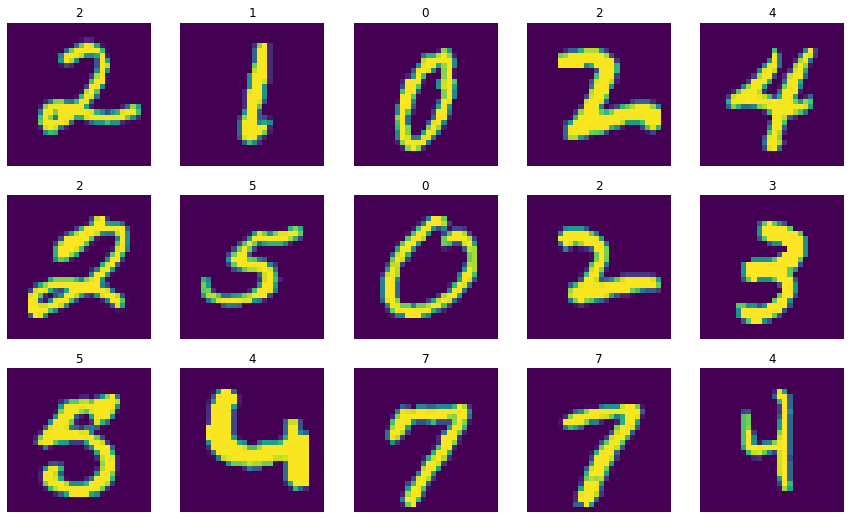

In [3]:
# Plot dimensions
ROWS, COLS = 3, 5
SCALE = 3

# Sampled images
pairs = list(zip(X_train, y_train))
samples = random.sample(pairs, ROWS * COLS)

# Plotting
fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS * SCALE, ROWS * SCALE))
for i, (img, digit) in enumerate(samples):
    row, col = i // COLS, i % COLS
    ax[row, col].imshow(img)
    ax[row, col].set_title(digit)
    ax[row, col].axis('off')

## 2 Model

### 2.2 Activation

We will use the sigmoid activation function as the non-linear layers of our network.

In [4]:
class Sigmoid:
    def func(self, x):
        return 1 / (1 + np.exp(-x))

    def grad(self, x):
        sig = self.func(x)
        return sig * (1 - sig)

### 2.1 Weight Initialization

We will use the Xavier Normal initialization method that goes well with the Sigmoid activation function.

https://365datascience.com/tutorials/machine-learning-tutorials/what-is-xavier-initialization/

In [5]:
class Xavier:
    def init(self, layer_sizes):
        return [
            np.random.normal(loc=0, scale=np.sqrt(2 / (size_from + size_to)), size=(size_from, size_to))
            for size_from, size_to in zip(layer_sizes[:-1], layer_sizes[1:])
        ]

### 2.3 Loss Function

Our task is a multi-class classification task, and so we will define our loss function to be the Cross Entropy Loss.

In [6]:
def softmax(x):
    exp = np.exp(x)
    return exp / np.sum(exp, axis=-1, keepdims=True)

def one_hot(num_classes, labels):
    return np.eye(num_classes)[labels].astype(bool)

class CrossEntropyLoss:    
    def func(self, y_true, y_pred):
        return -np.log(softmax(y_pred)[one_hot(y_pred.shape[1], y_true)]).sum() / y_true.size
    
    def grad(self, y_true, y_pred):
        return softmax(y_pred) - one_hot(y_pred.shape[1], y_true)  

### 2.4 Neural Network

We will define our Neural Network Classifier with some key components:
1. Feed-forward
2. Back-propagation
3. Weights update
4. Training loop
5. Validation

In [7]:
class NeuralNetworkClassifier:
    def __init__(self, 
                 input_size, 
                 hidden_sizes, 
                 output_size, 
                 weight_init_type=Xavier, 
                 activation_type=Sigmoid,
                 loss_type=CrossEntropyLoss,
                 lr=1e-2,
                 reg=0.0,
                 max_iter=20, 
                 batch_size=100, 
                 validation_size=0.2, 
                 shuffle=True):
        
        self.layer_sizes = [input_size, *hidden_sizes, output_size]
        self.weight_initializer = weight_init_type()
        self.weights = self.weight_initializer.init(self.layer_sizes)
        self.gradients = [np.zeros_like(w) for w in self.weights]
        self.activation = activation_type()
        self.loss = loss_type()

        self.lr = lr
        self.reg = reg        
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.validation_size = validation_size
        self.shuffle = shuffle
        
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, X):
        
        # Inputs for each layer (hidden & output)
        self.layer_inputs = [np.zeros((X.shape[0], size)) for size in self.layer_sizes[:-1]]
        self.activation_inputs = [np.zeros((X.shape[0], size)) for size in self.layer_sizes[1:]]
        
        # First layer inputs
        self.layer_inputs[0] = X
        
        # Calculate intermediate values
        for layer, weight in enumerate(self.weights[:-1]):
            
            # Linear layer
            self.activation_inputs[layer] = self.layer_inputs[layer] @ weight
            
            # Activation
            self.layer_inputs[layer + 1] = self.activation.func(self.activation_inputs[layer])
            
        # Last linear layer
        self.activation_inputs[-1] = self.layer_inputs[-1] @ self.weights[-1]
        self.output = self.activation_inputs[-1]
    
    def backward(self, y):
        
        # Gradient of loss w.r.t to last activation input
        delta = self.loss.grad(y, self.activation_inputs[-1])
        
        # Iterate over layers
        for layer in range(len(self.gradients) - 1, 0, -1):

            # Gradient of loss w.r.t layer weights
            self.gradients[layer] = self.layer_inputs[layer].T @ delta / y.size
            
            # Gradient of loss w.r.t to previous layer's input
            delta = self.activation.grad(self.activation_inputs[layer - 1]) * (delta @ self.weights[layer].T)

        # Last gradient of loss w.r.t first layer's weights
        self.gradients[0] = self.layer_inputs[0].T @ delta / y.size

    def step(self):
        
        # Update weights
        for layer, grad in enumerate(self.gradients):
            self.weights[layer] -= self.lr * (grad + self.reg * self.weights[layer])

    def single_iter(self, X, y, train=True):
        num_batches = y.size / self.batch_size
        iter_loss = 0
        iter_num_correct = 0
        
        # Iterate over batches
        for i in range(0, y.size, self.batch_size):
            X_batch, y_batch = X[i:i+self.batch_size], y[i:i+self.batch_size]
            self.forward(X_batch)
        
            # Back propagate
            if train:
                self.backward(y_batch)
                self.step()
                
            # Calculate loss & accuracy
            iter_loss += self.loss.func(y_batch, self.output)
            iter_num_correct += (np.argmax(softmax(self.output), axis=1) == y_batch).sum()
            
        return iter_loss / num_batches, 100 * iter_num_correct / y.size
        
    def get_time_spent(self, total=False):
        now = time.time()
        base = self.step_time if not total else self.start_time
        minutes = int(now - base) // 60 % 60
        seconds = int(now - base) % 60
        self.step_time = time.time()
        
        return f'{minutes:02d}:{seconds:02d}'
        
    def fit(self, X, y):
        self.start_time = time.time()
        self.step_time = self.start_time
        self.train_rows, self.val_rows = train_test_split(np.arange(X.shape[0]), test_size=self.validation_size, shuffle=self.shuffle, random_state=42)
        print(self)
        
        # Training iterations
        for self.iter in range(1, self.max_iter + 1):
            print(f'----- Iteration {self.iter}/{self.max_iter} -----')
            
            train_loss, train_accuracy = self.single_iter(X[self.train_rows, :], y[self.train_rows])
            print(f'  Train: Loss {train_loss:.3f}, Accuracy {train_accuracy:.2f} [{self.get_time_spent()}]')
            
            val_loss, val_accuracy = self.single_iter(X[self.val_rows, :], y[self.val_rows], train=False)
            print(f'  Validation: Loss {val_loss:.3f}, Accuracy {val_accuracy:.2f} [{self.get_time_spent()}]')
            
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)
            
        print(f'----- FINISHED [{self.get_time_spent(total=True)}] -----\n')
        
        return self

    def predict_proba(self, X):
        return softmax(reduce(lambda x, w: self.activation.func(x @ w), [X, *self.weights[:-1]]) @ self.weights[-1])

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)    

    def score(self, X, y):
        return (self.predict(X) == y).sum() / len(y)
    
    def __repr__(self):
        return f'[{"-".join(map(str, self.layer_sizes))}]_iter{self.max_iter}_lr{self.lr}_reg{self.reg}'

## 3 Experiments

In [8]:
warnings.filterwarnings('ignore')

We will define functions to help us save & load our trained models.

In [9]:
def save_model(model):
    with open(f'models/{model}', 'wb') as f:
        pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_model(model_path):
    with open(f'models/{model_path}', 'rb') as f:
        model = pickle.load(f)
    return model

We will define functions to help us run experiments and print their results

In [10]:
def plot_learning_curves(nns):
    num_iters = max([len(nn.train_losses) for nn in nns])
    iters = np.arange(1, num_iters + 1)

    # Plot Train & Validation Losses
    fig, ax = plt.subplots(2, 2, figsize=(20, 20))
    for nn in nns:
        ax[0][0].set_title("Train Loss")
        ax[0][0].plot(iters, nn.train_losses, label=nn)
        ax[0][1].set_title("Validation Loss")
        ax[0][1].plot(iters, nn.val_losses, label=nn)
        ax[1][0].set_title("Training Accuracy")
        ax[1][0].plot(iters, nn.train_accuracies, label=nn)
        ax[1][1].set_title("Validation Accuracy")
        ax[1][1].plot(iters, nn.val_accuracies, label=nn)
    
    # Labels and Legends
    for row in range(len(ax)):
        for col in range(len(ax[0])):
            ax[row][col].set_xlabel('Iterations')
            ax[row][col].legend(loc='best')
            
    for col in range(len(ax[0])):
        ax[0][col].set_ylabel('Loss')
        ax[1][col].set_ylabel('Accuracy')
    
def plot_confusion_matrix(ax, clf, X, y, tag):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y_true=y, y_pred=y_pred)
    
    sns.heatmap(cm, annot=cm, ax=ax)
    ax.set_ylabel("Ground Truth")
    ax.set_xlabel("Predictions")
    ax.set_title(f'{clf}, {tag} score: {clf.score(X, y):.3f}')
        
def run_experiment(experiment, data_size):
    for ex_args in experiment:
        nn = NeuralNetworkClassifier(input_size=X_train_flat.shape[1], 
                                     output_size=np.unique(y_train).size,
                                     **ex_args)
        save_model(nn.fit(X_train_flat[:data_size], y_train[:data_size]))

### 3.1 Network Width

**Experiment 1**: Different hidden layer sizes, single layer

In [ ]:
layer_sizes_1 = [1024, 512, 256, 128]

experiment_1 = [
    {
        "hidden_sizes": [size],
    }
    for size in layer_sizes_1
]

run_experiment(experiment=experiment_1, data_size=X_train.shape[0])

In [ ]:
plot_learning_curves([
    load_model(f'[784-{size}-10]_iter20_lr0.01_reg0.0')
    for size in layer_sizes_1
])

### 3.2 Network Depth

**Experiment 2**: Different hidden layer sizes, double layer

In [ ]:
layer_sizes_2 = [
    [1024, 1024],
    [1024, 512],
    [1024, 256],
    [512, 512]
]

experiment_2 = [
    {
        "hidden_sizes": sizes,   
    }
    for sizes in layer_sizes_2
]

run_experiment(experiment=experiment_2, data_size=X_train.shape[0])

In [ ]:
plot_learning_curves([
    load_model(f'[784-{size1}-{size2}-10]_iter20_lr0.01_reg0.0')
    for size1, size2 in layer_sizes_2
])

### 3.3 Learning Rates

**Experiment 3**: Different learning rates for single-layer networks.

In [ ]:
layer_sizes_3 = [1024, 512]
lrs_3 = [1e-2, 3e-3, 1e-3, 3e-4]

experiment_3 = [
    {
        "hidden_sizes": [size],
        "lr": lr,
        "max_iter": 40
    }
    for lr in lrs_3
    for size in layer_sizes_3
]

run_experiment(experiment=experiment_3, data_size=X_train.shape[0])

In [ ]:
plot_learning_curves([
    load_model(f'[784-{size}-10]_iter40_lr{lr}_reg0.0')
    for lr in lrs_3
    for size in layer_sizes_3
])

**Experiment 4**: Different learning rates for double-layer networks.

In [ ]:
layer_sizes_4 = [[1024, 1024], [1024, 512]]
lrs_4 = [3e-1, 1e-2, 3e-2, 1e-3]

experiment_4 = [
    {
        "hidden_sizes": sizes,
        "lr": lr,
        "max_iter": 40
    }
    for lr in lrs_4
    for sizes in layer_sizes_4
]

run_experiment(experiment=experiment_4, data_size=X_train.shape[0])

In [ ]:
plot_learning_curves([
    load_model(f'[784-{size1}-{size2}-10]_iter40_lr{lr}_reg0.0')
    for lr in lrs_4
    for size1, size2 in layer_sizes_4
])

### 3.4 Regulariztion

**Experiment 5**: Different L2-regularization coefficients.

In [ ]:
layer_sizes_6 = [[1024, 1024], [1024, 512]]
regs = [1e-2, 3e-3, 1e-3, 3e-4]

experiment_6 = [
    {
        "hidden_sizes": sizes,
        "lr": 3e-2,
        "reg": reg,
        "max_iter": 40
    }
    for reg in regs
    for sizes in layer_sizes_6
]

run_experiment(experiment=experiment_6, data_size=X_train.shape[0])

In [ ]:
plot_learning_curves([
    load_model(f'[784-{size1}-{size2}-10]_iter40_lr{lr}_reg0.0')
    for lr in lrs_4
    for size1, size2 in layer_sizes_4
])

## 4 Conclusion